## 시계열 분석

In [0]:
# time sereise analysis

In [0]:
## SMA
## 단순 이동 평균

def make_sma_arr(window_num): # 이동평균 함수 # id별 지정한 window에 맞게 이동평균 col추가
    ma_arr = np.array([])
    for i in df_month.store_id.unique():
        df_set = df_month[df_month.store_id == i]
        ma_arr = np.concatenate((ma_arr, df_set.amount.rolling(window=window_num).mean().values))
        
    return ma_arr

In [0]:
sma_month = df_month.copy()

sma_month.insert(7, 'amount_2ma', make_sma_arr(2))
sma_month.insert(8, 'amount_3ma', make_sma_arr(3))
sma_month.insert(9, 'amount_6ma', make_sma_arr(6))

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


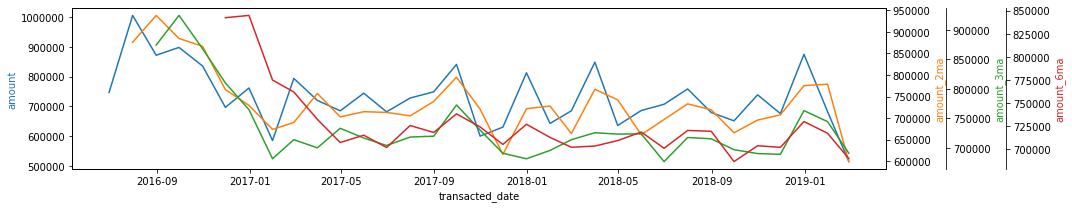

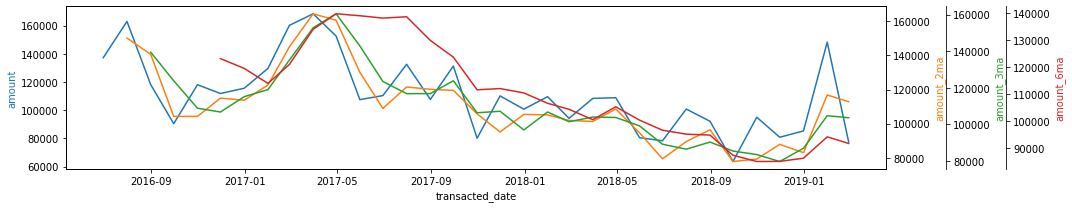

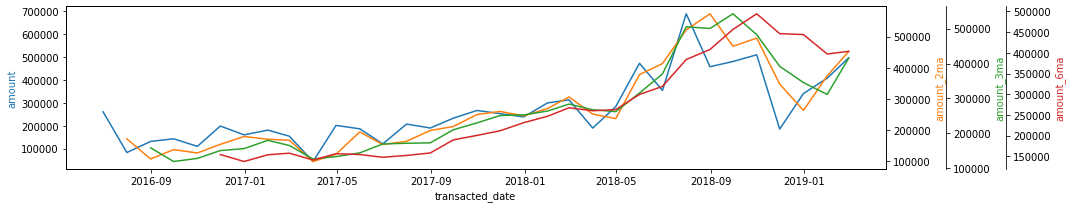

In [0]:
# 2,3,6개월 이동평균 결과 비교
for i in sma_month.store_id.unique()[:3]:
    plot_model_graph(sma_month, i, 'transacted_date', ['amount', 'amount_2ma', 'amount_3ma', 'amount_6ma'])

In [0]:
# 2,3,6개월 이동평균의 MAE Score

print("2 winodw SMA MAE Score : ", mae(sma_month.amount_2ma.fillna(0), sma_month.amount.values))
print("3 window SMA MAE Score : ", mae(sma_month.amount_3ma.fillna(0), sma_month.amount.values))
print("6 window SMA MAE Score : ", mae(sma_month.amount_6ma.fillna(0), sma_month.amount.values))

2 winodw SMA MAE Score :  180687.25906004856
3 window SMA MAE Score :  251607.45528312284
6 window SMA MAE Score :  387465.0993765708


In [0]:
## submisson을 위한 code

## ?????????

# rolling의 경우, window 3를 예를 들면 t 시점에 대한 값으로 t시점, t-1시점, t-2시점의 평균을 사용한다.
# 우리가 필요한 것은 t시점을 위해 t-1, t-2, t-3의 평균을 구하는 것이므로 함수를 생성하여 진행

## ** 기존 SMA 방식(위에서 한 방식)은 t시점까지의 이동평균을 구하기 위해 window가 3인경우, => t-2,t-1,t 시점의 평균을 구하는방식
## 우리는 t 시점의 데이터가 예측대상이므로, 방식을 바꾸어 t-3,t-2,t-1시점의 평균을 구할것.

def make_minus_rolling(data_frame, rolling_num):

    # 함수안의 함수
    def minus_shift_rolling(df_num, num): # 
        a = np.average(df_num.values[-num:]) # 예를들어, window가 3인경우 t-3,t-2,t-1 시점의 데이터 평균 구함
        b = np.average(np.append(df_set.values[-(num-1):], a)) # ???
        # np.append(arr,values) => 기존 arr에 추가할 values 지정
        if num > 2:
            c = np.average(np.append(np.append(df_set.values[-(num-2):], a), b))
        else:
            c = np.average((a, b))
        return np.sum((a, b, c))

    # 여기서 부터 실행

    minus_rolling_arr = np.array([])
    for i in data_frame.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount) # store_id 별 amount 
        minus_rolling_arr = np.concatenate((minus_rolling_arr, np.array([minus_shift_rolling(df_set, rolling_num)]))) # 함수안의 함수 적용하여 합침
        
    df_rolling = pd.DataFrame({'store_Id' : df_sub.store_id, 'amount' : minus_rolling_arr})
    
    return df_rolling

In [0]:
for i in range(2, 5):
    df_rolling = make_minus_rolling(df_month, i)
    # df_rolling.to_csv('/content/drive/My Drive/Time-Series/__data/sub/funda_{}_rolling_sub.csv'.format(i), index=False)

In [0]:
########### 지수 이동 평균

In [0]:
def make_ewm_arr(data_frame, span_num):
    arr_ewm = np.array([])
    for i in data_frame.store_id.unique():
        df_set = data_frame[data_frame.store_id == i]
        # 여기에서 지정하는 span값은 위 수식에서 N에 해당한다.
        arr_ewm = np.concatenate((arr_ewm, df_set.amount.ewm(span=span_num).mean().values))
    
    return arr_ewm

In [0]:
ewm_month = df_month.copy()

ewm_month.insert(7, 'amount_3ewm', make_ewm_arr(df_month, 3))
ewm_month.insert(8, 'amount_6ewm', make_ewm_arr(df_month, 6))

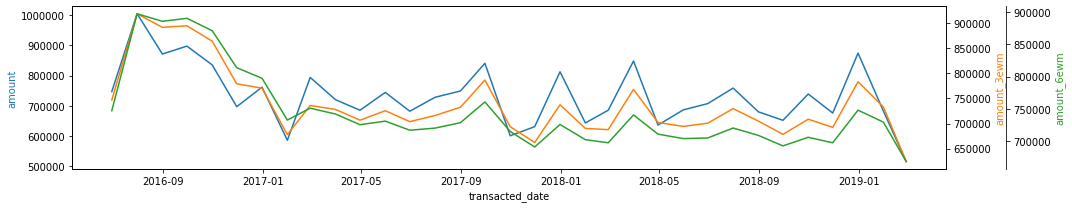

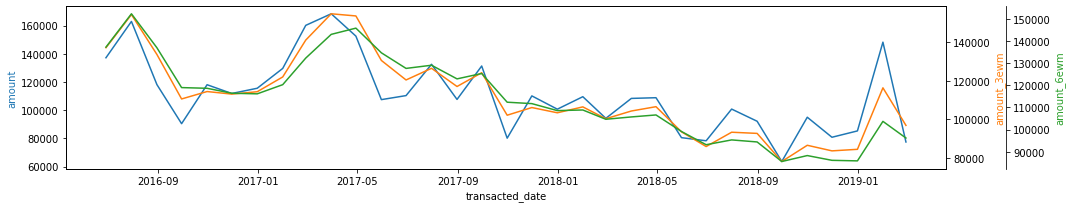

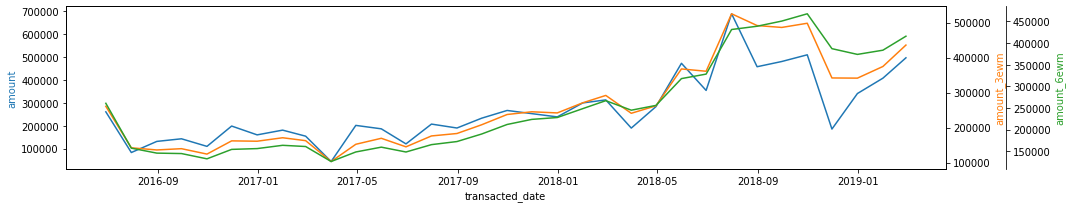

In [0]:
for i in ewm_month.store_id.unique()[:3]:
    plot_model_graph(ewm_month, i, 'transacted_date', ['amount', 'amount_3ewm', 'amount_6ewm'])

In [0]:
print("3 N EWM MAE Score : ", mae(ewm_month.amount_3ewm, sma_month.amount.values))
print("6 N EWM MAE Score : ", mae(ewm_month.amount_6ewm, sma_month.amount.values))

3 N EWM MAE Score :  134855.11946915495
6 N EWM MAE Score :  193447.63093078104


In [0]:
def make_wma_sub(data_frame, span_num):
    concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))
    wma_sub = np.array([])

    for i in df_month.store_id.unique():
        df_set = pd.DataFrame(data_frame[data_frame.store_id == i].amount)
        wma_train = pd.concat([df_set, concat_3mon], axis=0)

        num_sub = np.array([wma_train.amount.ewm(span=span_num).mean()['2019-03':].sum()])

        wma_sub = np.concatenate((wma_sub, num_sub))
        
    df_wma_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : wma_sub})
    
    return df_wma_sub

In [0]:
concat_3mon = pd.DataFrame(index=pd.to_datetime(['2019-03-31', '2019-04-30', '2019-05-31']))

df_set = pd.DataFrame(df_month[df_month.store_id == 0].amount)

wma_train = pd.concat([df_set,concat_3mon],axis=0)

num_sub = np.array([wma_train.amount.ewm(span=3).mean()['2019-03':].sum()])

wma_sub = np.array([])
wma_sub = np.concatenate((wma_sub,num_sub))
wma_sub
# df_wma_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : wma_sub})

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


array([1872660.39209917])

In [0]:
for i in range(2, 7):
    wma_sub = make_wma_sub(df_month, i)
    # wma_sub.to_csv('/content/drive/My Drive/Time-Series/__data/sub/funda_{}wma_sub.csv'.format(i), index=False)

In [0]:
## ARIMA

In [0]:
p = list(range(0, 6))
d = [0, 1, 2]
q = list(range(0, 6))

pdq = list(itertools.product(p, d, q))

In [0]:
%%time
df_set = df_month[df_month.store_id == 0]

size = int(len(df_set) * 0.7)
train = df_set[:size]
test = df_set[size:]

best_score = 10000000
best_param = 0
for param in pdq:
    try:
        arima_model = ARIMA(train.amount.values, order=param)
        result = arima_model.fit()
        if result.aic < best_score:
            best_score = result.aic
            best_param = param
    except:
        continue
        
set_arima = ARIMA(df_set.amount.values, order=best_param)
set_result = set_arima.fit()
set_pred = set_result.forecast(len(test))[0]

In [0]:
print("Mean value of store_id 0 :", df_set.amount.mean())
print("AIC Score of test :", best_score)
print("Best parameter of (p, d, q): ",best_param)

plot_train_test_pred_graph(train, test, set_pred)

In [0]:
Mean value of store_id 0 : 732559.7402597402
AIC Score of test : 557.6623843461919
Best parameter of (p, d, q):  (2, 2, 1)

In [0]:
%%time
arima_pred_arr = np.array([])
for i in df_month.store_id.unique()[:10]:
    df_set = df_month[df_month.store_id == i]

    best_score = 10000000000
    best_param = 0
    for param in pdq:
        try:
            arima_model = ARIMA(df_set.amount.values, order=param)
            result = arima_model.fit()
            # 최적 parameter는 fit에 저장되어 있는 AIC값을 기준으로 선정 한다.
            if result.aic < best_score:
                best_score = result.aic
                best_param = param
        except:
            continue

    
    arima_model = ARIMA(df_set.amount.values, order=best_param)
    arima_result = arima_model.fit()
    arima_pred = arima_result.forecast(3)[0]

    arima_pred_arr = np.concatenate((arima_pred_arr, np.array([arima_pred.sum()])))

In [0]:
arima_sum_sub = pd.DataFrame({'store_id' : df_sub.store_id, 'amount' : arima_pred_arr})
arima_sum_sub.to_csv('./__data/sub/funda_arima_front_sum_sub.csv', index=False)